# An Introduction to SageMaker Random Cut Forests

***Unsupervised anomaly detection on timeseries data a Random Cut Forest algorithm.***

---

1. [Introduction](#Introduction)
1. [Setup](#Setup)
1. [Training](#Training)
1. [Inference](#Inference)
1. [Epilogue](#Epilogue)

# Introduction
***

Amazon SageMaker Random Cut Forest (RCF) is an algorithm designed to detect anomalous data points within a dataset. Examples of when anomalies are important to detect include when website activity uncharactersitically spikes, when temperature data diverges from a periodic behavior, or when changes to public transit ridership reflect the occurrence of a special event.

In this notebook, we will use the SageMaker RCF algorithm to train an RCF model on the Numenta Anomaly Benchmark (NAB) EC2 Utilization Data  We will then use this model to predict anomalous events by emitting an "anomaly score" for each data point. The main goals of this notebook are,

* to learn how to obtain, transform, and store data for use in Amazon SageMaker;
* to create an AWS SageMaker training job on a data set to produce an RCF model,
* use the RCF model to perform inference with an Amazon SageMaker endpoint.

The following are ***not*** goals of this notebook:

* deeply understand the RCF model,
* understand how the Amazon SageMaker RCF algorithm works.

If you would like to know more please check out the [SageMaker RCF Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/randomcutforest.html).

# Setup

***

*This notebook was tested in Amazon SageMaker Studio on a ml.t3.medium instance with Python 3 (Data Science) kernel.*

Our first step is to setup our AWS credentials so that AWS SageMaker can store and access training data and model artifacts. We also need some data to inspect and to train upon.

## Select Amazon S3 Bucket

We first need to specify the locations where the original data is stored and where we will store our training data and trained model artifacts. ***This is the only cell of this notebook that you will need to edit.*** In particular, we need the following data:

* `bucket` - An S3 bucket accessible by this account.
* `prefix` - The location in the bucket where this notebook's input and output data will be stored. (The default value is sufficient.)

In [4]:
import boto3
import botocore
import sagemaker
import sys


bucket = sagemaker.Session().default_bucket()  # Feel free to change to another bucket you have access to
prefix = "sagemaker/rcf-transactions"
execution_role = sagemaker.get_execution_role()
region = boto3.Session().region_name



def check_bucket_permission(bucket):
    # check if the bucket exists
    permission = False
    try:
        boto3.Session().client("s3").head_bucket(Bucket=bucket)
    except botocore.exceptions.ParamValidationError as e:
        print(
            "Hey! You either forgot to specify your S3 bucket"
            " or you gave your bucket an invalid name!"
        )
    except botocore.exceptions.ClientError as e:
        if e.response["Error"]["Code"] == "403":
            print(f"Hey! You don't have permission to access the bucket, {bucket}.")
        elif e.response["Error"]["Code"] == "404":
            print(f"Hey! Your bucket, {bucket}, doesn't exist!")
        else:
            raise
    else:
        permission = True
    return permission


if check_bucket_permission(bucket):
    print(f"Training input/output will be stored in: s3://{bucket}/{prefix}")

Training input/output will be stored in: s3://sagemaker-us-east-1-973994155064/sagemaker/rcf-transactions


## Problem: EC2 Utilization Anamoly
<img src="img/MLFlow-1.png" width=800 height=450 />

## Obtain and Inspect Example Data 
### (Also Called EDA or Exploratory Data Analysis)
 
we will will public available EC2 Utilization Dataset that spans a few days collected at 5min intervals. 


<img src="img/MLFlow-2.png" width=800 height=450 />

## Download Data from S3.

1. using aws cli you can
> !aws s3 cp s3://yourbucketname/foldername/filename .

2. using boto3 
> import boto3 \
> s3 = boto3.client('s3') \
> s3.download_file('BUCKET_NAME', 'OBJECT_NAME', 'FILE_NAME')

In [6]:
pwd

'/root/veritoll'

In [7]:
# !aws s3 cp s3://feidemo/varconsdemo/ec2_cpu_utilization_5f5533.csv .

#data_filename = "simBankTransactions.csv"
data_filename = "CCT-Sir-John-Young-Car-2017-01-01-2021-09-30-quarter-hourly.csv"

!aws s3 cp ./data/$data_filename s3://$bucket/sagemaker/rcf-transactions/$data_filename

upload: data/CCT-Sir-John-Young-Car-2017-01-01-2021-09-30-quarter-hourly.csv to s3://sagemaker-us-east-1-973994155064/sagemaker/rcf-transactions/CCT-Sir-John-Young-Car-2017-01-01-2021-09-30-quarter-hourly.csv


In [8]:
%%time

import pandas as pd
import urllib.request

s3 = boto3.client("s3")
tran_data = pd.read_csv(f'data/{data_filename}', delimiter=",")
# ec2_data.columns=['timestamp', 'util_percent']

CPU times: user 104 ms, sys: 8.81 ms, total: 112 ms
Wall time: 125 ms


Before training any models it is important to inspect our data, first. Perhaps there are some underlying patterns or structures that we could provide as "hints" to the model or maybe there is some noise that we could pre-process away. The raw data looks like this:

In [9]:
tran_data.head()

,timestamp,value
0,2017-01-01 00:00:00,14
1,2017-01-01 00:15:00,39
2,2017-01-01 00:30:00,75
3,2017-01-01 00:45:00,116
4,2017-01-01 01:00:00,124


In [10]:
tran_data['timestamp'] = pd.to_datetime(tran_data['timestamp'])

In [11]:
tran_data['hour'] = tran_data['timestamp'].dt.hour

In [50]:
import matplotlib.pyplot as plt 
plt.style.use('fivethirtyeight')
%matplotlib inline
import datetime
import matplotlib.dates as mdates

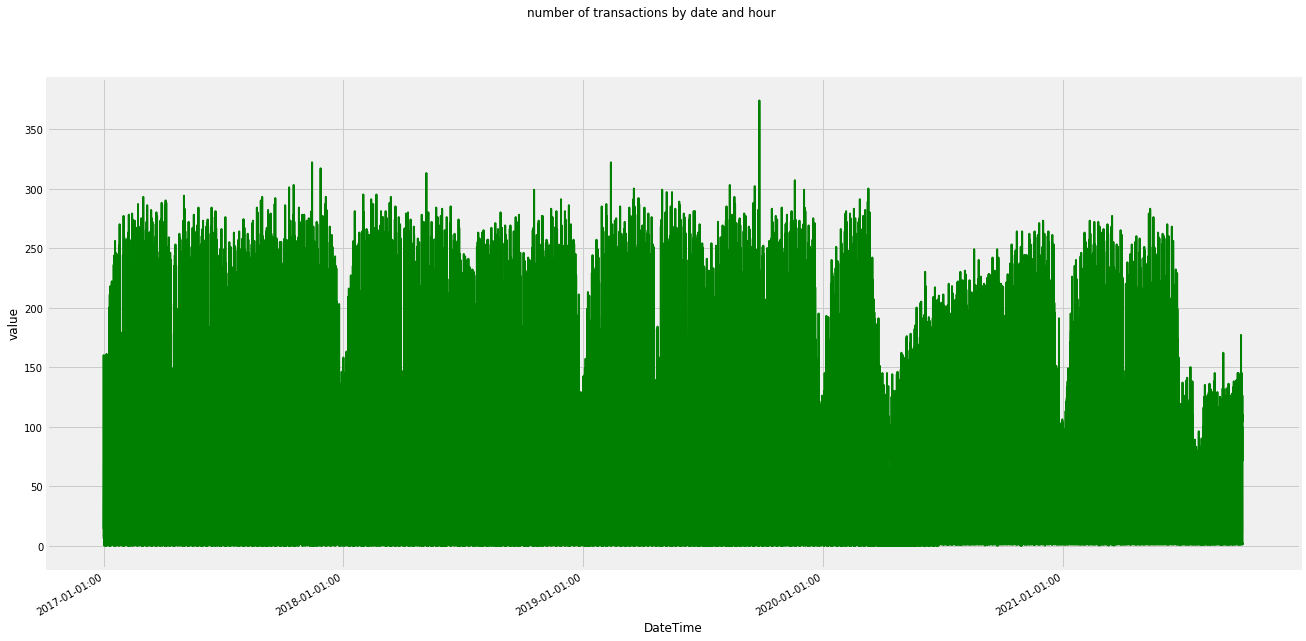

In [14]:
fig, ax = plt.subplots(figsize=(20,10))
fig.suptitle("number of transactions by date and hour")
ax.plot(tran_data['timestamp'], tran_data['value'], color='green',linewidth=2)
ax.set(xlabel="DateTime", ylabel="value")
# plt.xticks(rotation='vertical')
fig.autofmt_xdate() 
years_fmt = mdates.DateFormatter('%Y-%m-%d:%H')
ax.xaxis.set_major_formatter(years_fmt)

Human beings are visual creatures so let's take a look at a plot of the data.

In [27]:
tran_anamoly1=tran_data[(tran_data['timestamp']>datetime.datetime(2020,2,15,0,0,0)) & (tran_data['timestamp']<datetime.datetime(2020,3,15,3,0,0))][['timestamp', 'value']]
tran_anamoly2=tran_data[(tran_data['timestamp']>datetime.datetime(2020,3,15,18,0,0)) & (tran_data['timestamp']<datetime.datetime(2020,4,15,23,0,0))][['timestamp', 'value']]

Human beings are also extraordinarily good at perceiving patterns. Note, for example the two dates 2020-02-27 and 2020-03-15, There is a spike in EC2 Utilization, this is obvious visually, However there are/could be other anamolies compared to daily usage average. Let's begin by looking at the two dates we identified closely

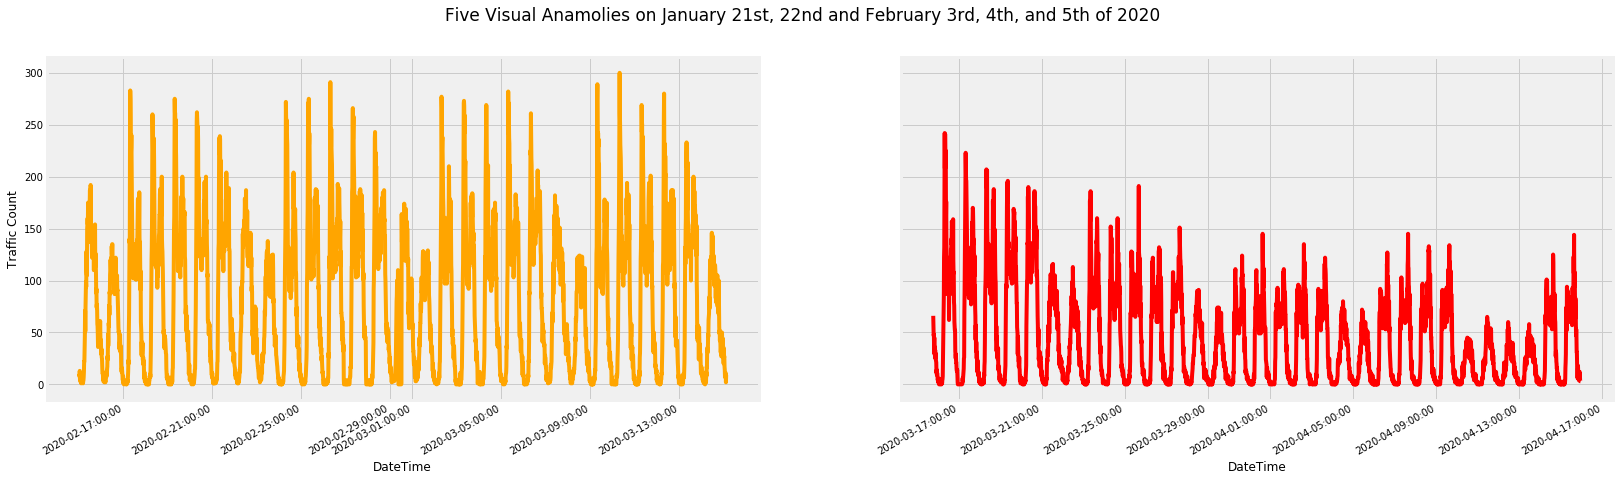

In [33]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(25,7),sharey=True)
fig.suptitle('Five Visual Anamolies on January 21st, 22nd and February 3rd, 4th, and 5th of 2020',fontsize=17)
ax1.plot(tran_anamoly1['timestamp'], tran_anamoly1['value'], color='orange')
ax1.set(xlabel="DateTime", ylabel="Traffic Count")
# plt.xticks(rotation='vertical')
fig.autofmt_xdate() 
years_fmt = mdates.DateFormatter('%Y-%m-%d:%H:%M')
ax1.xaxis.set_major_formatter(years_fmt)

ax2.plot(tran_anamoly2['timestamp'], tran_anamoly2['value'], color='red')
ax2.set(xlabel="DateTime")
# plt.xticks(rotation='vertical')
ax2.xaxis.set_major_formatter(years_fmt)

As we can see the data is more or less periodic around the 250 in first graph and starts to tail off after the pandameic to a lower volume around 150. What if we look in July 2020 after the pandemic rules stabilized a bit ?

In [29]:
tran_anamoly3=tran_data[(tran_data['timestamp']>datetime.datetime(2020,7,1,0,0,0)) & (tran_data['timestamp']<datetime.datetime(2020,7,15,3,0,0))][['timestamp', 'value']]


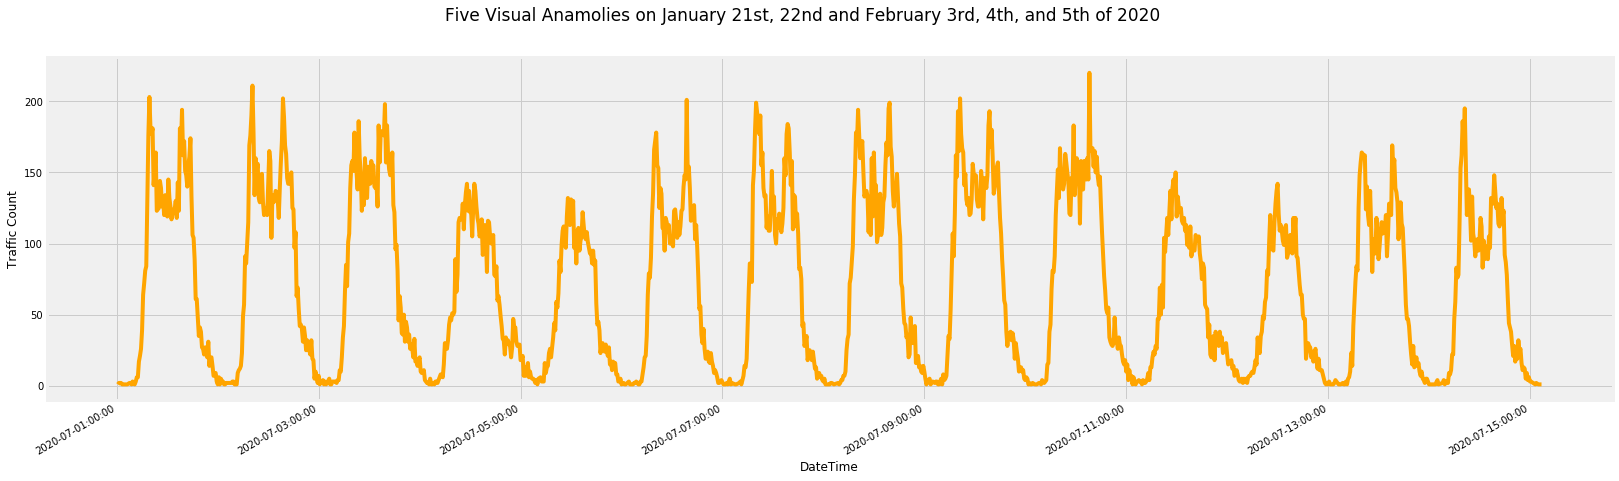

In [32]:
fig, (ax3) = plt.subplots(1,1,figsize=(25,7))
fig.suptitle('Five Visual Anamolies on January 21st, 22nd and February 3rd, 4th, and 5th of 2020',fontsize=17)
ax3.plot(tran_anamoly3['timestamp'], tran_anamoly3['value'], color='orange')
ax3.set(xlabel="DateTime", ylabel="Traffic Count")
# plt.xticks(rotation='vertical')
fig.autofmt_xdate() 
years_fmt = mdates.DateFormatter('%Y-%m-%d:%H:%M')
ax3.xaxis.set_major_formatter(years_fmt)

Looks like it slowly ramped up to 200s

# Training

***
<img src="img/MLFlow-4.png" width=800 height=450 />

Next, we configure a SageMaker training job to train the Random Cut Forest (RCF) algorithm on the Traffic data.

## Hyperparameters

Particular to a SageMaker RCF training job are the following hyperparameters:

* **`num_samples_per_tree`** - the number randomly sampled data points sent to each tree. As a general rule, `1/num_samples_per_tree` should approximate the the estimated ratio of anomalies to normal points in the dataset.
* **`num_trees`** - the number of trees to create in the forest. Each tree learns a separate model from different samples of data. The full forest model uses the mean predicted anomaly score from each constituent tree.
* **`feature_dim`** - the dimension of each data point. *This is not required for the code below if you are importing RandomCutForest from Sagemaker SDk, it is calculated for you*

In addition to these RCF model hyperparameters, we provide additional parameters defining things like the EC2 instance type on which training will run, the S3 bucket containing the data, and the AWS access role. Note that,

* Recommended instance type: `ml.m4`, `ml.c4`, or `ml.c5`
* Current limitations:
  * The RCF algorithm does not take advantage of GPU hardware.

In [31]:
from sagemaker import RandomCutForest

session = sagemaker.Session()

# specify general training job information
rcf = RandomCutForest(
    role=execution_role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    data_location=f"s3://{bucket}/{prefix}/",
    output_path=f"s3://{bucket}/{prefix}/output",
    num_samples_per_tree=512,
    num_trees=50,
)

# automatically upload the training data to S3 and run the training job
rcf.fit(rcf.record_set(tran_data.value.to_numpy().reshape(-1, 1)))

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2022-03-03 19:03:35 Starting - Starting the training job...
2022-03-03 19:03:37 Starting - Launching requested ML instancesProfilerReport-1646334215: InProgress
.........
2022-03-03 19:05:26 Starting - Preparing the instances for training......
2022-03-03 19:06:37 Downloading - Downloading input data...
2022-03-03 19:07:06 Training - Downloading the training image...
2022-03-03 19:07:27 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[03/03/2022 19:07:32 INFO 139701828368192] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-conf.json: {'num_samples_per_tree': 256, 'num_trees': 100, 'force_dense': 'true', 'eval_metrics': ['accuracy', 'precision_recall_fscore'], 'epochs': 1, 'mini_batch_size': 1000, '_log_level': 'info', '_kvstore': 'dist_async', '_num_kv_servers': 'auto', '_num_gpus': 'auto', '_tuning_objective_metric'

In [30]:
tran_data.to_csv("values_and_others.csv",index=False, header=False)

In [27]:
pd.DataFrame(tran_data.value).to_csv("values_only.csv", index=False, header=False)

In [32]:
# !aws s3 cp values_only.csv s3://feidemo/veritoll/values_only.csv
!aws s3 cp values_and_others.csv s3://feidemo/veritoll/values_and_others.csv

upload: ./values_and_others.csv to s3://feidemo/veritoll/values_and_others.csv


If you see the message 

> `===== Job Complete =====`

at the bottom of the output logs then that means training successfully completed and the output RCF model was stored in the specified output path. You can also view information about and the status of a training job using the AWS SageMaker console. Just click on the "Jobs" tab and select training job matching the training job name, below:


or if you see [*] next to cell for a long time, may be the kernel/notebook got out of sync with the internet. so check the sagemaker console, Training Jobs to see if the job is complete. 

In [34]:
print(f"Training job name: {rcf.latest_training_job.job_name}")

Training job name: randomcutforest-2022-03-03-19-03-35-425


# Inference

***


<img src="img/MLFlow-5.png" width=800 height=450 />

A trained Random Cut Forest model does nothing on its own. We now want to use the model we computed to perform inference on data. In this case, it means computing anomaly scores from input time series data points.

We create an inference endpoint using the SageMaker Python SDK `deploy()` function from the job we defined above. We specify the instance type where inference is computed as well as an initial number of instances to spin up. We recommend using the `ml.c5` instance type as it provides the fastest inference time at the lowest cost.

In [35]:
rcf_inference = rcf.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


----------!

Congratulations! You now have a functioning SageMaker RCF inference endpoint. You can confirm the endpoint configuration and status by navigating to the "Endpoints" tab in the AWS SageMaker console and selecting the endpoint matching the endpoint name, below: 

In [36]:
print(f"Endpoint name: {rcf_inference.endpoint}")

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Endpoint name: randomcutforest-2022-03-03-19-12-44-762


## Data Serialization/Deserialization

We can pass data in a variety of formats to our inference endpoint. In this example we will demonstrate passing CSV-formatted data. Other available formats are JSON-formatted and RecordIO Protobuf. We make use of the SageMaker Python SDK utilities `csv_serializer` and `json_deserializer` when configuring the inference endpoint.

In [37]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

rcf_inference.serializer = CSVSerializer()
rcf_inference.deserializer = JSONDeserializer()

Let's pass the training dataset, in CSV format, to the inference endpoint so we can automatically detect the anomalies we saw with our eyes in the plots, above. Note that the serializer and deserializer will automatically take care of the datatype conversion from Numpy NDArrays.

For starters, let's only pass in the first six datapoints so we can see what the output looks like.

In [19]:
tran_data.to_csv("s3://feidemo/veritoll/tran_data.csv", index=False, header=False)

In [38]:
tran_data_numpy = tran_data.value.to_numpy().reshape(-1, 1)
print(tran_data_numpy[:6])
results = rcf_inference.predict(
    tran_data_numpy[:6], initial_args={"ContentType": "text/csv", "Accept": "application/json"}
)

[[ 14]
 [ 39]
 [ 75]
 [116]
 [124]
 [144]]


## Computing Anomaly Scores

Now, let's compute and plot the anomaly scores from the entire EC2 Utilization dataset.

In [39]:
results = rcf_inference.predict(tran_data_numpy)
scores = [datum["score"] for datum in results["scores"]]

# add scores to EC2 data frame and print first few values
tran_data["score"] = pd.Series(scores, index=tran_data.index)
tran_data.head()

,timestamp,value,hour,score
0,2017-01-01 00:00:00,14,0,0.901396
1,2017-01-01 00:15:00,39,0,0.875349
2,2017-01-01 00:30:00,75,0,0.872564
3,2017-01-01 00:45:00,116,0,0.829815
4,2017-01-01 01:00:00,124,1,0.881177


In [40]:
start, end = 0, len(tran_data)
# start, end = 5500, 6500
tran_data_subset = tran_data[start:end]

In [41]:
tran_data_subset.head()

,timestamp,value,hour,score
0,2017-01-01 00:00:00,14,0,0.901396
1,2017-01-01 00:15:00,39,0,0.875349
2,2017-01-01 00:30:00,75,0,0.872564
3,2017-01-01 00:45:00,116,0,0.829815
4,2017-01-01 01:00:00,124,1,0.881177


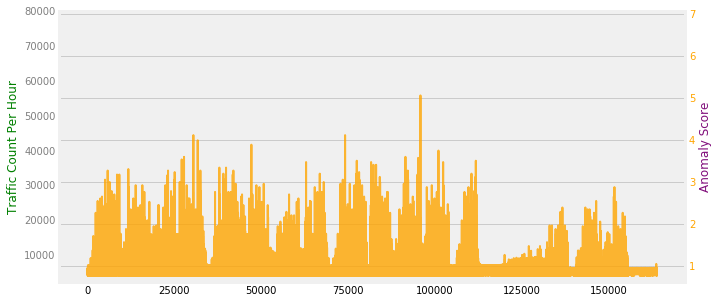

In [78]:
fig2, ax1 = plt.subplots(figsize=(30,5))
ax2 = ax1.twinx()
#
# *Try this out* - change `start` and `end` to zoom in on the
# anomaly found earlier in this notebook
#
start, end = 0, len(tran_data)
# start, end = 5500, 6500
tran_data_subset = tran_data[start:end]

ax1.plot(tran_data_subset["value"], color="gray",linewidth=2)
ax2.plot(tran_data_subset["score"], color="orange", alpha=0.8,linewidth=2)

ax1.grid(which="major", axis="both")

ax1.set_ylabel("Traffic Count Per Hour", color="green")
ax2.set_ylabel("Anomaly Score", color="C5")

ax1.tick_params("y", colors="gray")
ax2.tick_params("y", colors="orange")

ax1.set_ylim(2000, 80000)
ax2.set_ylim(min(scores)*0.8, 1.4 * max(scores))
fig2.set_figwidth(10)

Note that the anomaly score spikes where our eyeball-norm method suggests there is an anomalous data point as well as in some places where our eyeballs are not as accurate.

Below we print and plot any data points with scores greater than 3 standard deviations (approx 99.9th percentile) from the mean score.

In [79]:
score_mean = tran_data["score"].mean()
score_std = tran_data["score"].std()
score_cutoff = score_mean + 20 * score_std

anomalies = tran_data_subset[tran_data_subset["score"] > score_cutoff]
anomalies


,timestamp,value,hour,score
27775,2017-10-17 07:45:00,303,7,3.591667
30464,2017-11-14 08:00:00,322,8,4.108569
31711,2017-11-27 07:45:00,317,7,3.985517
47166,2018-05-07 07:30:00,313,7,3.880725
74142,2019-02-12 07:30:00,322,7,4.108569
91518,2019-08-12 07:30:00,303,7,3.591667
95838,2019-09-26 07:30:00,374,7,5.053386
95839,2019-09-26 07:45:00,332,7,4.332418
95840,2019-09-26 08:00:00,322,8,4.108569
101023,2019-11-19 07:45:00,307,7,3.741088


In [80]:
ax2.plot(anomalies.index, anomalies.score, "ko",markersize=6);

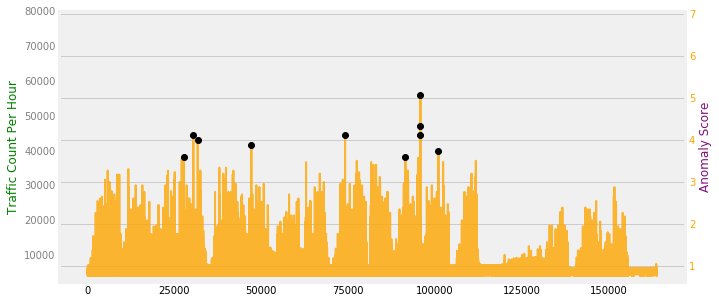

In [81]:
fig2

With the current hyperparameter choices we see that the three-standard-deviation threshold, while able to capture the known anomalies as well as the ones apparent in the ridership plot, is rather sensitive to fine-grained peruturbations and anomalous behavior. Adding trees to the SageMaker RCF model could smooth out the results as well as using a larger data set.

## Stop and Delete the Endpoint

Finally, we should delete the endpoint before we close the notebook.

To do so execute the cell below. Alternately, you can navigate to the "Endpoints" tab in the SageMaker console, select the endpoint with the name stored in the variable `endpoint_name`, and select "Delete" from the "Actions" dropdown menu. 

In [82]:
sagemaker.Session().delete_endpoint(rcf_inference.endpoint)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


# Epilogue

---

## Problem: Data Augmentation with Shingling
<img src="img/MLFlow-6.png" width=800 height=450 />

We used Amazon SageMaker Random Cut Forest to detect anomalous datapoints in a EC2 Utilization dataset. In these data the anomalies occurred when ridership was uncharacteristically high or low. However, the RCF algorithm is also capable of detecting when, for example, data breaks periodicity or uncharacteristically changes global behavior.

Depending on the kind of data you have there are several ways to improve algorithm performance. One method, for example, is to use an appropriate training set. If you know that a particular set of data is characteristic of "normal" behavior then training on said set of data will more accurately characterize "abnormal" data.

Another improvement is make use of a windowing technique called "shingling". This is especially useful when working with periodic data with known period, such as the EC2 Utilization dataset used above. The idea is to treat a period of $P$ datapoints as a single datapoint of feature length $P$ and then run the RCF algorithm on these feature vectors. That is, if our original data consists of points $x_1, x_2, \ldots, x_N \in \mathbb{R}$ then we perform the transformation,

```
data = [[x_1],            shingled_data = [[x_1, x_2, ..., x_{P}],
        [x_2],    --->                     [x_2, x_3, ..., x_{P+1}],
        ...                                ...
        [x_N]]                             [x_{N-P}, ..., x_{N}]]

```

In [12]:
import numpy as np


def shingle(data, shingle_size):
    num_data = len(data)
    shingled_data = np.zeros((num_data - shingle_size, shingle_size))

    for n in range(num_data - shingle_size):
        shingled_data[n] = data[n : (n + shingle_size)]
    return shingled_data


# single data with shingle size=12 (half a day)
shingle_size = 12
prefix_shingled = "sagemaker/randomcutforest_shingled"
tran_data_shingled = shingle(tran_data.values[:, 1], shingle_size)
print(tran_data_shingled)

[[ 14.  39.  75. ...  91.  58.  25.]
 [ 39.  75. 116. ...  58.  25.  31.]
 [ 75. 116. 124. ...  25.  31.  25.]
 ...
 [ 22.  15.  12. ...   8.   5.   1.]
 [ 15.  12.  13. ...   5.   1.   3.]
 [ 12.  13.   7. ...   1.   3.   2.]]


We create a new training job and and inference endpoint. (Note that we cannot re-use the endpoint created above because it was trained with one-dimensional data.)

### Iterate: Train again with newly Shingled Data

<img src="img/MLFlow-7.png" width=800 height=450 />

In [14]:
from sagemaker import RandomCutForest

session = sagemaker.Session()

# specify general training job information
rcf = RandomCutForest(
    role=execution_role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    data_location=f"s3://{bucket}/{prefix}/",
    output_path=f"s3://{bucket}/{prefix}/output",
    num_samples_per_tree=512,
    num_trees=50,
)

In [15]:
session = sagemaker.Session()

# specify general training job information
rcf = RandomCutForest(
    role=execution_role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    data_location=f"s3://{bucket}/{prefix_shingled}/",
    output_path=f"s3://{bucket}/{prefix_shingled}/output",
    num_samples_per_tree=512,
    num_trees=50,
)

# automatically upload the training data to S3 and run the training job
rcf.fit(rcf.record_set(tran_data_shingled))

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2022-03-06 17:05:58 Starting - Starting the training job...
2022-03-06 17:06:25 Starting - Preparing the instances for trainingProfilerReport-1646586358: InProgress
.........
2022-03-06 17:07:47 Downloading - Downloading input data...
2022-03-06 17:08:22 Training - Downloading the training image...
2022-03-06 17:08:53 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[03/06/2022 17:09:00 INFO 139740887095104 integration.py:636] worker started
[03/06/2022 17:09:00 INFO 139740887095104] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-conf.json: {'num_samples_per_tree': 256, 'num_trees': 100, 'force_dense': 'true', 'eval_metrics': ['accuracy', 'precision_recall_fscore'], 'epochs': 1, 'mini_batch_size': 1000, '_log_level': 'info', '_kvstore': 'dist_async', '_num_kv_servers': 'auto', '_num_gpus': 'auto', '_tuning_objective

### Let's look at Inference after Retraining
<img src="img/MLFlow-7.png" width=800 height=450 />

In [16]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

rcf_inference = rcf.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

rcf_inference.serializer = CSVSerializer()
rcf_inference.deserializer = JSONDeserializer()

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


-----------!

In [17]:
print(rcf_inference.content_type, rcf_inference.accept)

text/csv ('application/json',)


Using the above inference endpoint we compute the anomaly scores associated with the shingled data.

In [84]:
rcf_inference.endpoint_name

'randomcutforest-2022-03-06-17-09-41-110'

In [37]:
len(tran_data)

163937

In [57]:
tran_data[(tran_data['timestamp']>datetime.datetime(2020,2,15,0,0,0)) & (tran_data['timestamp']<datetime.datetime(2020,3,15,3,0,0))][['timestamp', 'value']]

,timestamp,value
109441,2020-02-15 00:15:00,10
109442,2020-02-15 00:30:00,8
109443,2020-02-15 00:45:00,9
109444,2020-02-15 01:00:00,13
109445,2020-02-15 01:15:00,5
...,...,...
112231,2020-03-15 01:45:00,9
112232,2020-03-15 02:00:00,11
112233,2020-03-15 02:15:00,11
112234,2020-03-15 02:30:00,2


In [64]:
# Score the shingled datapoints
results = rcf_inference.predict(
    tran_data_shingled[109441:112235], initial_args={"ContentType": "text/csv", "Accept": "application/json"}
)
scores = np.array([datum["score"] for datum in results["scores"]])

# compute the shingled score distribution and cutoff and determine anomalous scores
score_mean = scores.mean()
score_std = scores.std()
score_cutoff = score_mean + 3 * score_std

anomalies = scores[scores > score_cutoff]
anomaly_indices = 109441+np.arange(len(scores))[scores > score_cutoff]

print(anomalies)
print(anomaly_indices)

[1.44641349 1.40796064 1.44014099 1.40614428 1.40262665 1.50280787
 1.46043326 1.53722347 1.48456311 1.41956202 1.53062849 1.47326693
 1.54031971 1.46528712 1.60850919 1.40957515 1.51811013 1.46679973
 1.48776708 1.47209576 1.52726499 1.63823119 1.40282934 1.40117201
 1.50340881 1.40453418 1.58247511 1.4525175  1.4703022  1.49674421
 1.47023617 1.46040235 1.4943515  1.54674166 1.60049016 1.48735038
 1.5209125  1.50883919 1.50489775 1.40912582 1.41818753 1.46895032
 1.40829418 1.55236712 1.41017049 1.63896912 1.46951914 1.43893308
 1.49418786 1.46569465 1.49628285 1.39153081 1.50582569 1.49344737
 1.38928307 1.41332788 1.44672063 1.47345778 1.43683562 1.51696835
 1.62837238 1.77518226 1.59067797 1.46525756 1.45626298 1.41749446
 1.40078176 1.42633813 1.45186719 1.53066996 1.58101424 1.52416305
 1.39234164 1.42615681]
[109654 109655 109656 109657 109658 109660 109661 109662 109852 109853
 109854 109949 110332 110333 110334 110422 110424 110425 110427 110428
 110429 110430 110431 110520 1

Finally, we plot the scores from the shingled data on top of the original dataset and mark the score lying above the anomaly score threshold.

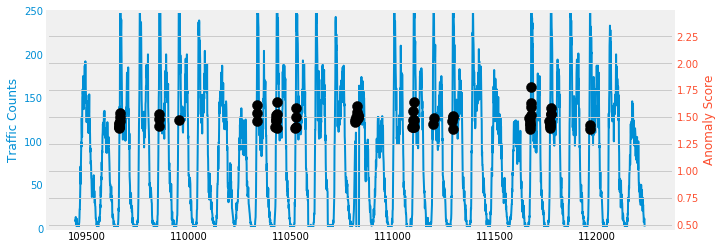

In [71]:
fig.clear()
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

#
# *Try this out* - change `start` and `end` to zoom in on the
# anomaly found earlier in this notebook
#
# start, end = 0, len(tran_data)
start, end=109441, 112235
tran_data_subset = tran_data[start:end]

ax1.plot(tran_data_subset["value"], color="C0", alpha=1, linewidth=2)
# ax2.plot(scores, color="C1", linewidth=2, alpha=0.3)
ax2.scatter(anomaly_indices, anomalies, color="k", s=100)

ax1.grid(which="major", axis="both")
ax1.set_ylabel("Traffic Counts", color="C0")
ax2.set_ylabel("Anomaly Score", color="C1")
ax1.tick_params("y", colors="C0")
ax2.tick_params("y", colors="C1")
ax1.set_ylim(0, 250)
ax2.set_ylim(min(scores), 1.4 * max(scores))
fig.set_figwidth(10)

We see that with this particular shingle size, hyperparameter selection, and anomaly cutoff threshold that the shingled approach captures different anomalous events:

In general, the number of trees, sample size, and anomaly score cutoff are all parameters that a data scientist may need experiment with in order to achieve desired results. 

The use of a labeled test dataset allows the used to obtain common accuracy metrics for anomaly detection algorithms. For more information about Amazon SageMaker Random Cut Forest see the [AWS Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/randomcutforest.html).

In [91]:
rcf_pred=sagemaker.predictor.Predictor('randomcutforest-2022-03-03-20-18-33-894')


In [92]:
rcf_pred.delete_endpoint()

In [96]:
# rcf_pred.delete_predictor()